# From Bayes to BERT: Classification Approaches in NLP
***
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
***
## Summary

This presentation looks at the various ways we can build and evaluate NLP pipelines for text classification tasks like author identification or sentiment analysis. The presentation plans to cover the following approaches:

0. [Data Exploration](#data-exploration)
1. [Simple Knowledge Base](#simple-knowledge-base)
2. [Naive Bayes Classifier](#naive-bayes-classifier)
3. [K-Nearest Neighbors](#k-nearest-neighbors)
4. [Support Vector Machine](#support-vector-machines)
5. [Logistic Regression](#logistic-regression)
6. [Feed-Forward Neural Network](#feed-forward-neural-network)
7. [Recurrent Neural Network](#recurrent-neural-network)
8. [Simple Transformer](#simple-transformer)
9. HuggingFace Transformers
***
## Necessary Imports & Setup
### General

In [1]:
# These imports are required to run the notebook
from pathlib import Path

import nltk
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Metrics

In [2]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             roc_curve,)

### Preprocessing & Vectorization

In [90]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,
                                             ENGLISH_STOP_WORDS,)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

### Machine-Learning Models

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

### Deep-Learning Models

In [6]:
from collections import OrderedDict
from torch.utils.data import (Dataset, 
                              DataLoader,)

import torch

import torch.nn as nn
import torch.optim as optim

### Ignore The Knowledge Base Implementation

The knowledge base was modified from a previous homework I did for *CS2710: Foundations in AI*, and as such I will not be uploading it to the repository. Please run this to ignore the cells that require this import

In [7]:
ALEJANDRO = True  # I'm me, lol

if ALEJANDRO:    
    from kb.Propositional_KB_agent import *

### Load The Datasets

The dataset was gotten from [Project Gutenberg](https://www.gutenberg.org). I already cleaned up the texts a bit (remove chapter headings, the pre-/post-ambles and some of the extra whitespace). I also converted the works into a `.csv` for the presentation, but there's still some more cleaning we can easily do here. While we're focusing on Jane Austen vs. Herman Melville classification, we also have some Tolstoy in the mix.

In [9]:
PATH = Path("./datasets/")  # Overkill in this instance but useful in general
df = pd.read_pickle(PATH / "dataset.pkl")

# Remove any forgotten whitespace and puncuations (already sentences)
CLEANER = re.compile(r"[“”\"\\\n\t\r,\.\?\!\[\]\{\}\(\)]", re.I)

def clean(line: str) -> str: 
    return CLEANER.sub("", line.lower())

# Create a tokenized word column
df["line"] = df["line"].map(clean)
df["tokens"] = df["line"].map(nltk.word_tokenize)

df.sample(10)


,author,book,line,tokens
87684,melville,moby_dick,soon it went down and while with oars suspende...,"[soon, it, went, down, and, while, with, oars,..."
233875,tolstoy,anna_karenina,stepan arkadyevitch was telling his sister-in-...,"[stepan, arkadyevitch, was, telling, his, sist..."
138382,tolstoy,war_and_peace,more please: more,"[more, please, :, more]"
51537,austen,emma,jane fairfax was an orphan the only child of m...,"[jane, fairfax, was, an, orphan, the, only, ch..."
40509,austen,pride_and_prejudice,they soon outstripped the others; and when the...,"[they, soon, outstripped, the, others, ;, and,..."
45001,austen,pride_and_prejudice,did you on reading it give any credit to its c...,"[did, you, on, reading, it, give, any, credit,..."
147565,tolstoy,war_and_peace,pale with quivering lips pierre snatched the copy,"[pale, with, quivering, lips, pierre, snatched..."
70873,melville,redburn,stick to it wellingborough thought i; don’t gi...,"[stick, to, it, wellingborough, thought, i, ;,..."
151680,tolstoy,war_and_peace,if you please your excellency pétrusha has bro...,"[if, you, please, your, excellency, pétrusha, ..."
31095,austen,lady_susan,s vernon,"[s, vernon]"


### Useful Helper Functions

In [10]:
def get_metrics(targets, predictions):

    acc = accuracy_score(y_true=targets, y_pred=predictions)
    prec = precision_score(y_true=targets, y_pred=predictions, average="macro")
    rec = recall_score(y_true=targets, y_pred=predictions, average="macro")
    f1 = f1_score(y_true=targets, y_pred=predictions, average="macro")
    conf = confusion_matrix(y_true=targets, y_pred=predictions)

    return acc, prec, rec, f1, conf

In [11]:
def plot_confusion_matrix(cm, labels):   
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [12]:
def plot_calibration_curve(y_test, probs, bins = 10, label = ""):
    # Modified from geeksforgeeks https://www.geeksforgeeks.org/calibration-curves/
    # Creating Calibration Curve
    x, y = calibration_curve(y_test, probs, n_bins = 10)
    
    # Plot calibration curve
    
    # Plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
    
    # Plot model's calibration curve
    plt.plot(y, x, marker = '.', label = label)
    
    leg = plt.legend(loc = 'upper left')
    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()

In [13]:
def plot_roc_curve(y_test, probs, label=""):
    # https://medium.com/@shuv.sdr/na%C3%AFve-bayes-classification-in-python-f869c2e0dbf1
    # Plot AUC/ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr, tpr, label=label, color = 'firebrick')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.box(False)
    ax.legend()

In [14]:
def train_dl(model: nn.Module, epochs: int, dataloader: DataLoader,
             criterion, optimizer) -> list[float]:
    
    steps = len(dataloader)  # The batch size
    loss = None
    loss_tracker = []  # Save the loss at every check

    for epoch in range(epochs):

        for i, (inputs, label) in enumerate(dataloader):

            # Forward
            y_pred = model(inputs)
            loss = criterion(y_pred, label)

            # Backpropagation
            loss.backward()

            # Update
            optimizer.step()
            optimizer.zero_grad()

            # Show statistics and track loss change over time
            if i % 900 == 0:
                print(f'epoch: {epoch + 1}/{epochs}, step: {i}/{steps}, loss:{loss.item(): .5f}')
                loss_tracker.append(loss.item())

    print(f"Final loss: {loss.item()}")

    return loss_tracker

In [15]:
def plot_loss(loss, epochs, model_name):
    sns.lineplot(x = np.linspace(start=1, stop=epochs, num=4 * epochs), y=loss)
    plt.title(model_name)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

***
## Data Exploration

Let's briefly look at our data before we get started. First, what are the authors and which of their works are we basing our decision on?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256359 entries, 0 to 256358
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   author  256359 non-null  object
 1   book    256359 non-null  object
 2   line    256359 non-null  object
 3   tokens  256359 non-null  object
dtypes: object(4)
memory usage: 7.8+ MB


In [28]:
print(f"Authors: {', '.join([name.capitalize() for name in df.author.unique()])}")
print(f"Works: {', '.join(df.book.unique())}")
print(f"Total Tokens: {sum([len(toks) for toks in df.tokens.to_list()]):,d}")

Authors: Austen, Melville, Tolstoy
Works: sense_and_sensibility, mansfield_park, lady_susan, pride_and_prejudice, emma, redburn, moby_dick, the_condifence_man, piazza_tales, bartleby, war_and_peace, anna_karenina
Total Tokens: 6,253,371


Let's look at tokens specifically. Here, we look at the **Type-Token Ratio**, this helps us understand how *diverse* our tokens are. A TTR closer to 1 means we have many unique tokens.

$$\mathrm{TTR} = \frac{ | \mathrm{set(tokens) | }}{| \mathrm{sequence(tokens)} |}$$

In [35]:
tokens = [toks for tok_list in df.tokens.to_list() for toks in tok_list]
print(tokens[:10])
print(f"TTR: {len(set(tokens)) / len(tokens):.5f}")

['\ufeffthe', 'family', 'of', 'dashwood', 'had', 'long', 'been', 'settled', 'in', 'sussex']
TTR: 0.00804


In [69]:
# Per book
sub_ttrs = []
for book in df.book.unique():
    sub_df = df[df.book == book]
    sub_toks = [toks for tok_list in sub_df.tokens.to_list() for toks in tok_list]
    sub_ttrs.append(len(set(sub_toks)) / len(sub_toks))
    print(f"{book.capitalize()} TTR: {len(set(sub_toks)) / len(sub_toks):.5f}")

# Total
sub_ttrs.append(len(set(tokens)) / len(tokens))

Sense_and_sensibility TTR: 0.01963
Mansfield_park TTR: 0.01727
Lady_susan TTR: 0.04211
Pride_and_prejudice TTR: 0.01813
Emma TTR: 0.02045
Redburn TTR: 0.03444
Moby_dick TTR: 0.03024
The_condifence_man TTR: 0.03768
Piazza_tales TTR: 0.04612
Bartleby TTR: 0.07086
War_and_peace TTR: 0.01150
Anna_karenina TTR: 0.01307


/tmp/ipykernel_12063/3376992347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=books, y=sub_ttrs, palette=palette)


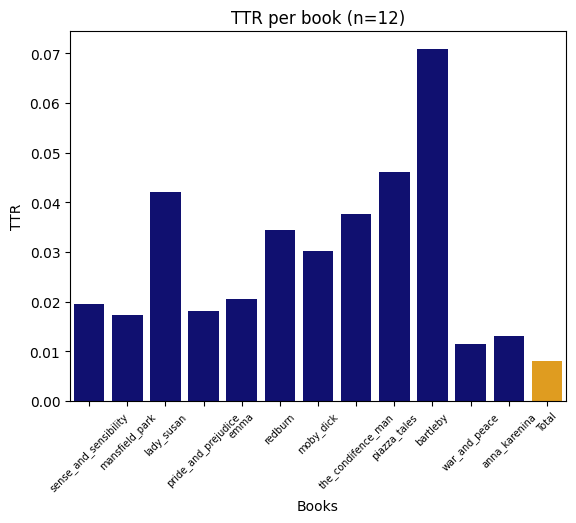

In [82]:
books = np.append(df.book.unique(), ["Total"], axis=0)
palette = ['orange' if x == "Total" else 'navy' for x in books]
sns.barplot(x=books, y=sub_ttrs, palette=palette)
plt.xticks(books, rotation=45, size=7)
plt.xlabel("Books")
plt.ylabel("TTR")
plt.title(f"TTR per book (n={len(df.book.unique())})")
plt.show()

Now for authors.

In [84]:
# Per author
sub_ttrs = []
for author in df.author.unique():
    sub_df = df[df.author == author]
    sub_toks = [toks for tok_list in sub_df.tokens.to_list() for toks in tok_list]
    sub_ttrs.append(len(set(sub_toks)) / len(sub_toks))
    print(f"{author.capitalize()} TTR: {len(set(sub_toks)) / len(sub_toks):.5f}")

# Total
sub_ttrs.append(len(set(tokens)) / len(tokens))

Austen TTR: 0.00955
Melville TTR: 0.01982
Tolstoy TTR: 0.00888


/tmp/ipykernel_12063/2569198944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=authors, y=sub_ttrs, palette=palette)


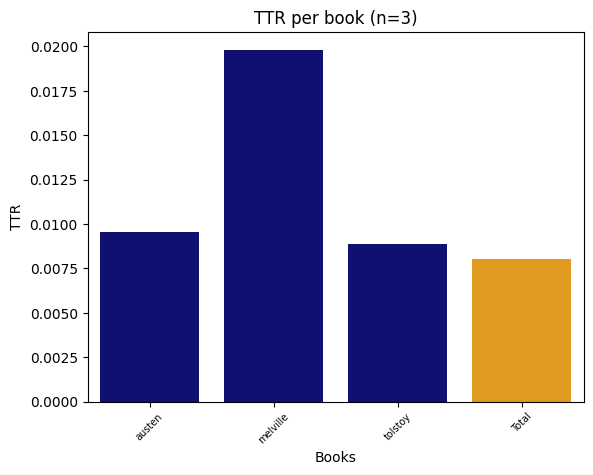

In [85]:
authors = np.append(df.author.unique(), ["Total"], axis=0)
palette = ['orange' if x == "Total" else 'navy' for x in authors]
sns.barplot(x=authors, y=sub_ttrs, palette=palette)
plt.xticks(authors, rotation=45, size=7)
plt.xlabel("Books")
plt.ylabel("TTR")
plt.title(f"TTR per book (n={len(df.author.unique())})")
plt.show()

We should definitely see what are the most common words in the dataset. This is probably going to be a lot of stop words (*the*, *a*, *but*, *and*, etc.), but who knows...

In [34]:
# Use the nltk.FreqDist class!
toks_freq = nltk.FreqDist(tokens)
print(toks_freq)

<FreqDist with 50283 samples and 6253371 outcomes>


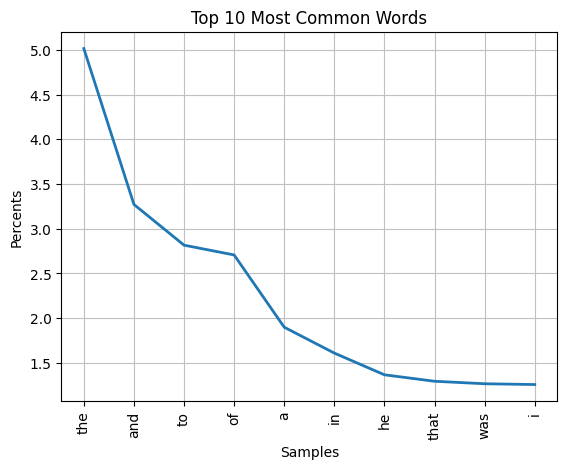

<Axes: title={'center': 'Top 10 Most Common Words'}, xlabel='Samples', ylabel='Percents'>

In [67]:
# Top ten
toks_freq.plot(10, title="Top 10 Most Common Words", percents=True)

What do you notice about the most common words? What about their percentages sticks out? Lastly, let's look at the most common **non-stopwords** and their TTR. Unicode quotations gotten from [here](https://www.cl.cam.ac.uk/~mgk25/ucs/quotes.html).

In [101]:
puncts = {',', '"', "'", "'", "‘", "’", '“', '”',
          ';', ':', '/', '\\',  '(', ')', '[', ']',
          '{', '}',}
full_stop = ENGLISH_STOP_WORDS.union(puncts)
non_stop = [tok for tok in tokens if tok not in full_stop]
print(f"TTR: {len(set(non_stop)) / len(non_stop):.5f}")

TTR: 0.01943


In [102]:
non_stop_freqs = nltk.FreqDist(non_stop)
print(non_stop_freqs)

<FreqDist with 49970 samples and 2571507 outcomes>


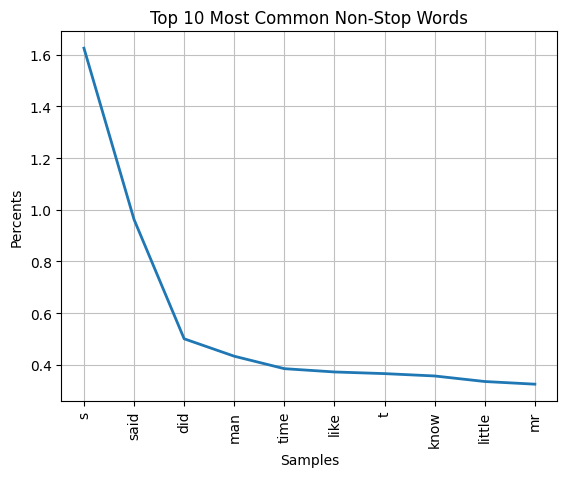

<Axes: title={'center': 'Top 10 Most Common Non-Stop Words'}, xlabel='Samples', ylabel='Percents'>

In [103]:
non_stop_freqs.plot(10, title="Top 10 Most Common Non-Stop Words", percents=True)

What do you notice here? Pay attention to the percentages! Now that we took a small look at our data, let's get into it!
***
## Simple Knowledge Base

While not necessarily used for classification, knowledge bases are a way to represent given rules (implications [`p -> q`]) and facts (literals [`p`]) about a *domain of discourse,* a group of objects. From these rules and facts, we can algorithmically deduce new rules (forward chaining) or prove new theorems (backward chaining).

In [13]:
# Get all the sentences for Emma and Moby Dick
if ALEJANDRO:
    kb_df = df[(df.book == "emma") | (df.book == "moby_dick")]
    kb_df.sample(10)

In [14]:
# Define the rules for Jane Austen and Herman Melville
if ALEJANDRO:
    austen = {'Emma', 'Harriet', 'Weston', 'Knightley', 
            'Elton','Woodhouse', 'Jane', 'Fairfax', 
            'Churchill', 'Frank', 'Hartfield', 'Bates', 
            'Highbury', 'Perry', 'Cole', 'Goddard', 
            'Campbell', 'Donwell', 'Dixon', 'Taylor',}

    melville = {'Ahab','Queequeg', 'Pequod', 'Bildad', 
                'Stubb', 'Starbuck', 'Peleg', 'Pip', 
                'Tashtego', 'Charley'}

    austen = [Rule(f"R{i}", [name.lower()], "emma") for i, name in enumerate(austen)]
    melville = [Rule(f"R{i}", [name.lower()], "moby_dick") for i, name in enumerate(melville)]

    kb_austen = KB(init_RB=austen)
    kb_melville = KB(init_RB=melville)

In [15]:
if ALEJANDRO:
    kb_austen.print_RB()

R0
If: ['cole']
Then: emma
 
R1
If: ['bates']
Then: emma
 
R2
If: ['fairfax']
Then: emma
 
R3
If: ['weston']
Then: emma
 
R4
If: ['hartfield']
Then: emma
 
R5
If: ['elton']
Then: emma
 
R6
If: ['knightley']
Then: emma
 
R7
If: ['highbury']
Then: emma
 
R8
If: ['jane']
Then: emma
 
R9
If: ['campbell']
Then: emma
 
R10
If: ['churchill']
Then: emma
 
R11
If: ['donwell']
Then: emma
 
R12
If: ['dixon']
Then: emma
 
R13
If: ['taylor']
Then: emma
 
R14
If: ['perry']
Then: emma
 
R15
If: ['harriet']
Then: emma
 
R16
If: ['goddard']
Then: emma
 
R17
If: ['frank']
Then: emma
 
R18
If: ['emma']
Then: emma
 
R19
If: ['woodhouse']
Then: emma
 


Since our knowledge base is simple, this becomes a simple check on the rules. No forward or backward chaining necessary.

In [16]:
if ALEJANDRO:
    def predict(tokens):

        # Reset the facts each time
        kb_austen.reset_FB()
        kb_melville.reset_FB()

        kb_austen.add_facts(tokens)
        kb_melville.add_facts(tokens)

        if forwardchain(kb_austen, "emma"):
            return "emma"
        elif forwardchain(kb_melville, "moby_dick"):
            return "moby_dick"
        else:
            return "no_answer"
            
    kb_df["prediction"] = kb_df["tokens"].map(predict)

    kb_df.sample(10)

/tmp/ipykernel_27235/2958747777.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kb_df["prediction"] = kb_df["tokens"].map(predict)


/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2639
Precision: 0.6662
Recall: 0.1961
F1 Score: 0.2888


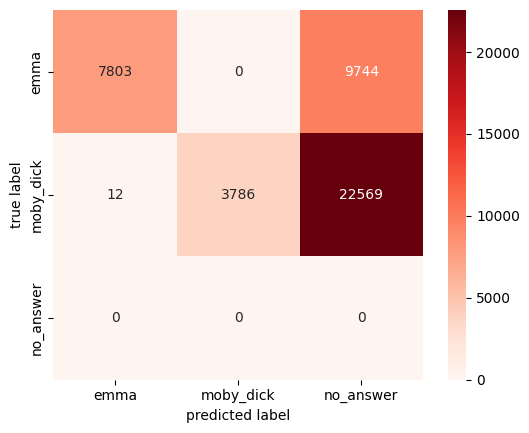

In [17]:
# Check the metrics
if ALEJANDRO:

    acc, prec, rec, f1, conf = get_metrics(targets=kb_df["book"], predictions=kb_df["prediction"])
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plot_confusion_matrix(conf, labels=["emma", "moby_dick", "no_answer"])

***
## Naive Bayes Classifier
The Naive Bayes Classifier uses Bayes' rule to predict if a given string of text is one of two classes.

$$P(\mathrm{tag} \vert \mathrm{words}) = \frac{P(\mathrm{words} \vert \mathrm{tag}) \times P(\mathrm{tag})}{P(\mathrm{words})}$$

But what exactly are the $\mathrm{words}$ in this case? Sure, we could use the raw counts of each word, but that might not give us enough information. NBC assumes *feature independence* and that the features are unordered (*bag of words*) meaning it does not consider how the probability changes as more words are added. We want words that appear more to have more weight, and we want to capture something about the relationship between these words. This is *feature engineering.*

First, let's get our data in a simpler format. Let's start with turning our labels (authors and books) into numbers!

In [18]:
authors = LabelEncoder()
df["author_label"] = authors.fit_transform(df.author)

books = LabelEncoder()
df["book_label"] = authors.fit_transform(df.book)

df.sample(2)

,author,book,line,tokens,author_label,book_label
72899,melville,redburn,the former were a timid silent trio who used t...,"[the, former, were, a, timid, silent, trio, wh...",1,8
105221,melville,the_condifence_man,homicides and murderers some call those contri...,"[homicides, and, murderers, some, call, those,...",1,10


First, let's just predict between Jane Austen and Herman Melville. We need to filter our dataset for only these two authors and then create a training-testing split!

In [19]:
nb1_df = df[(df.author == "austen") | (df.author == "melville")]

X_train, X_test, y_train, y_test = train_test_split(nb1_df["line"].to_list(), nb1_df["author_label"].to_list(), train_size=0.7, random_state=42)

print(X_train[0])
print(y_train[0])

print(len(X_train), len(X_test))

elinor only laughed
0
88691 38011


To start off, let's use simple *count-based features*. This means a word's numerical representation is simply the number of times it appears in the dataset.

In [20]:
example = CountVectorizer(max_features=10, max_df=0.7, ngram_range=(1, 3), stop_words="english")
counts = example.fit_transform(X_train)

print(counts.shape)
print(example.vocabulary_)

(88691, 10)
{'mr': 5, 'time': 9, 'think': 8, 'like': 2, 'little': 3, 'mrs': 6, 'man': 4, 'said': 7, 'good': 1, 'did': 0}


We can combine models and feature preprocessing via *pipelines!*

In [21]:
nb_pipe = make_pipeline(CountVectorizer(max_features=2000, max_df=0.7, ngram_range=(1, 3), stop_words="english"),
                           MultinomialNB())

nb_pipe.fit(X=X_train, y=y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.7, max_features=2000,
                                 ngram_range=(1, 3), stop_words='english')),
                ('multinomialnb', MultinomialNB())])

Let's test it to see how it performs on the training data

In [22]:
predictions = nb_pipe.predict(X_test)

Accuracy: 0.8864
Precision: 0.8864
Recall: 0.8864
F1 Score: 0.8864


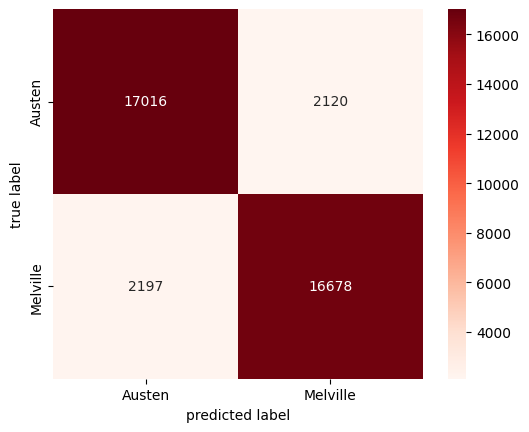

In [23]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

Label metrics are good, but they don't tell us anything about the model's probability labelling. Remember, this is all ultimately based on probabilities! Sklearn hides this process from us, splitting the labels at the 0.5 threshold.

$$\mathrm{Label}(\mathrm{label}_{0}, \mathrm{label}_{1}, \mathrm{words}) = 0 \ \mathrm{if} \ (P(\mathrm{label}_{0} \vert \mathrm{words})) < 0.5 \ \mathrm{else} \ 1 $$

Let's look at the actual probabilities this time and examine the model's *calibration!*

In [24]:
prob_preds = nb_pipe.predict_proba(X_test)

print(prob_preds[0])

[3.34151681e-15 1.00000000e+00]


Let's look at the model's **calibration curve**! Essentially, the model's probabilities for a label should match the frequency we see that label in the dataset!

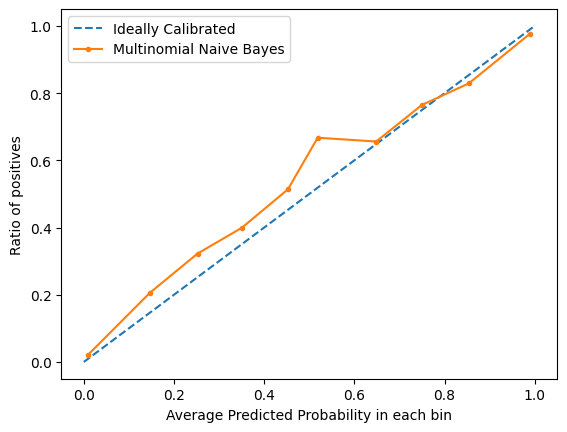

In [25]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

Let's also look at the **Area Under the Receiver Operator Curve (AUROC)**, which tells us how our model performs at different classification thresholds!

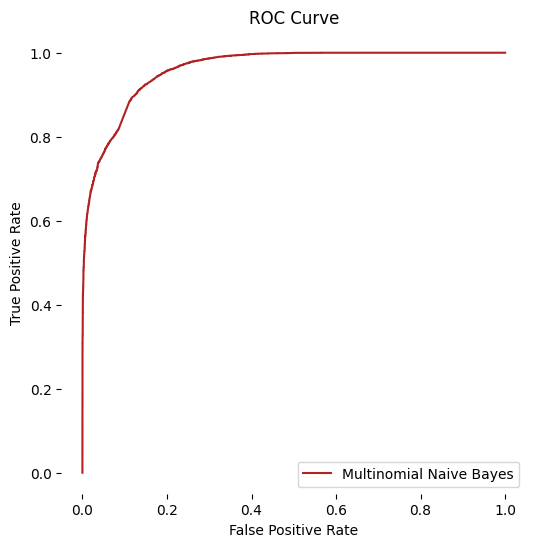

In [26]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

As we can see, our model isn't well calibrated despite its accuracy on the testing data.
***
## K-Nearest Neighbors

This method works by looking at "nearby" outputs. We get an output based on the feature weights and check what similar outputs were from our training data.

### TF-IDF Vectors

These vectors are similar to the count-based vectors from before, but now words are assigned "weight" depending on their importance. The word "dexterity" doesn't tell us much about what author it could be, but the word "Emma" or "ship" could! We also need to consider the words occurrence frequency though, if a word appears a lot, it's less useful. Thus, we get **Term-Frequency Inverse-Document Frequency**!

$$\mathrm{tf}(\mathrm{term}, \mathrm{document}) = 1 + \log(\mathrm{count}(\mathrm{term}, \mathrm{document})) \ \mathrm{if} \ \mathrm{count}(\mathrm{term}, \mathrm{document}) > 0 \ \mathrm{else} 0$$

$$idf(\mathrm{term}) = \log \left( \frac{N}{\mathrm{total \ count}(i)} \right)$$

$$tfidf(\mathrm{term}, \mathrm{document}) = \mathrm{tf}(\mathrm{term}, \mathrm{document}) \times idf(\mathrm{term})$$

Let's make K-Nearest Neighbors using TF-IDF!

In [27]:
# Make the pipeline!
k_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                       KNeighborsClassifier(n_neighbors=10))

k_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [28]:
predictions = k_pipe.predict(X_test)

Accuracy: 0.6597
Precision: 0.7171
Recall: 0.6614
F1 Score: 0.6371


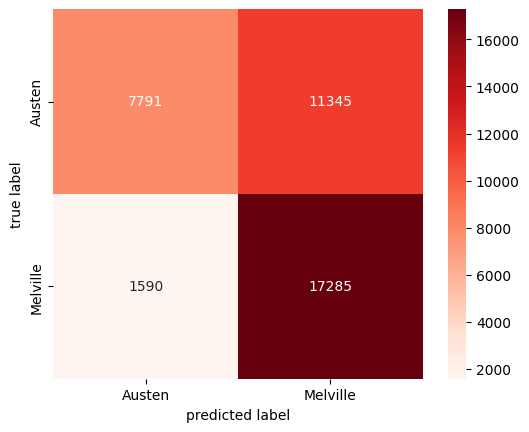

In [29]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [30]:
prob_preds = k_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.2 0.8]


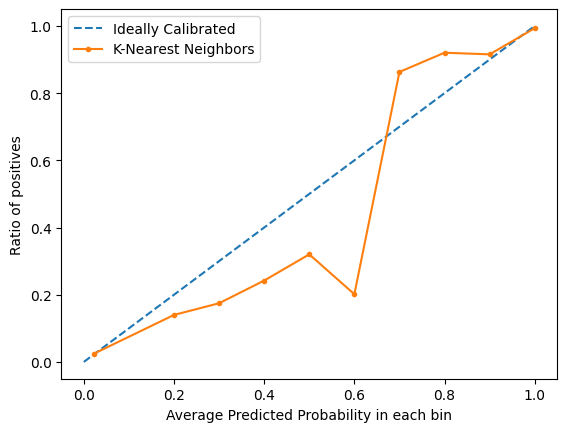

In [31]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="K-Nearest Neighbors")

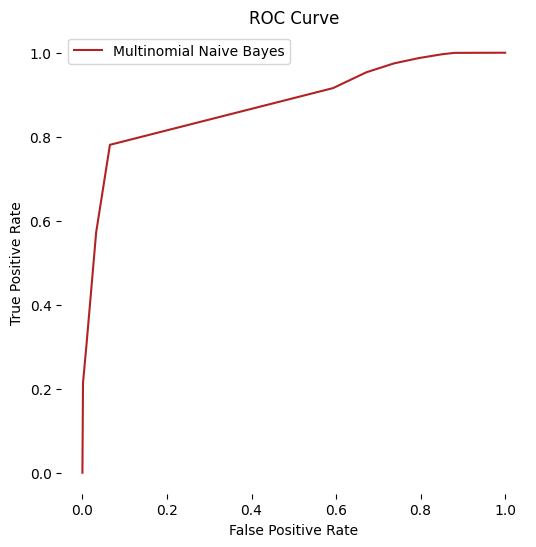

In [32]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

While our label-based metrics went down, the overall calibration is better!
***
## Support Vector Machines

My favorite machine-learning model because the name sounds cool! Also abbreviated as SVMs, these bad boys take the output space of our training data and finds a line such that it is the maximumally separates our classes; this divides the output space into two, the two regions we will use to clasify our results!

In [33]:
# Make the pipeline!
svm_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LinearSVC(C=1E2))

svm_pipe.fit(X_train, y_train)

/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('linearsvc', LinearSVC(C=100.0))])

In [34]:
predictions = svm_pipe.predict(X_test)

Accuracy: 0.9040
Precision: 0.9042
Recall: 0.9041
F1 Score: 0.9040


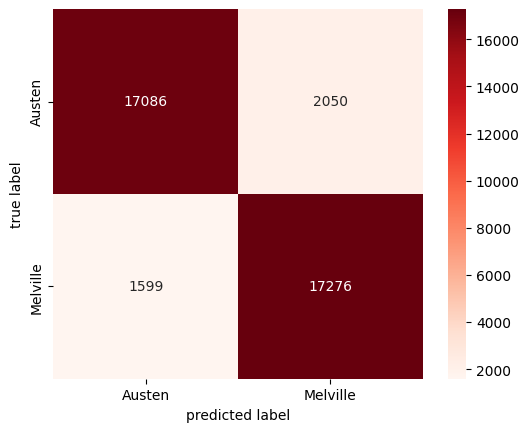

In [35]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [36]:
# Might be some slight discrepancy due to sklearn's implementation
prob_preds = svm_pipe.decision_function(X_test)

print(prob_preds[0])

5.791465755887931


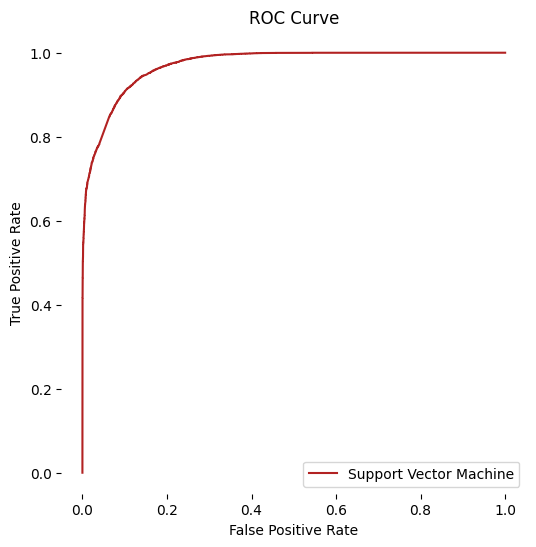

In [37]:
plot_roc_curve(y_test, prob_preds, label="Support Vector Machine")

So far, this is our best model for both calibration and accuracy!
***
## Logistic Regression

This is a very interesting classification technique. It is essentially a linear regression model with a final "layer" that transforms our real number output to be bounded within [0, 1]. This function is called the inverse log-odds (logit) function.

### Linear Regression

$$\eta = \beta_{0} + \beta_{1} x_{1} + \dots + \beta_{n} x_{n}$$

### Logit Function

$$\mathrm{logit}(\eta) = \ln \left( \frac{\eta}{1 - \eta} \right)$$

### Inverse Logit (Softmax)

$$\mathrm{softmax} = \mu = \frac{\exp(\eta)}{1 + \exp(\eta)}$$

![sigmoid](sigmoid.png)

[Link](https://math.stackexchange.com/questions/3816925/how-to-adjust-logit-functions-input-domain)

In [38]:
# Make the pipeline!
log_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga"))

log_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, penalty='elasticnet',
                                    solver='saga'))])

In [39]:
predictions = log_pipe.predict(X_test)

Accuracy: 0.9034
Precision: 0.9039
Recall: 0.9036
F1 Score: 0.9034


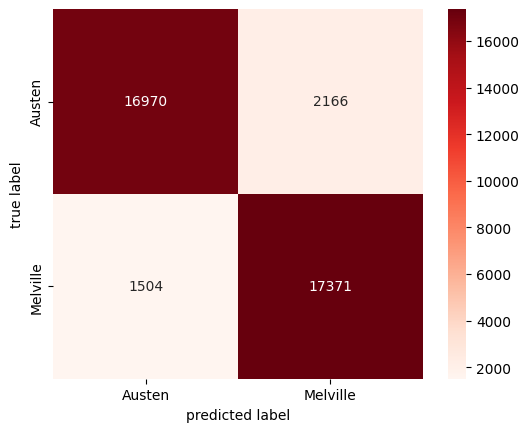

In [40]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [41]:
prob_preds = log_pipe.predict_proba(X_test)

print(prob_preds[0])

[2.12402118e-04 9.99787598e-01]


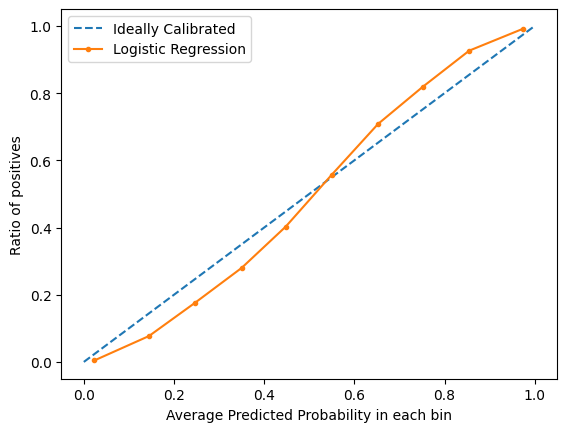

In [42]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

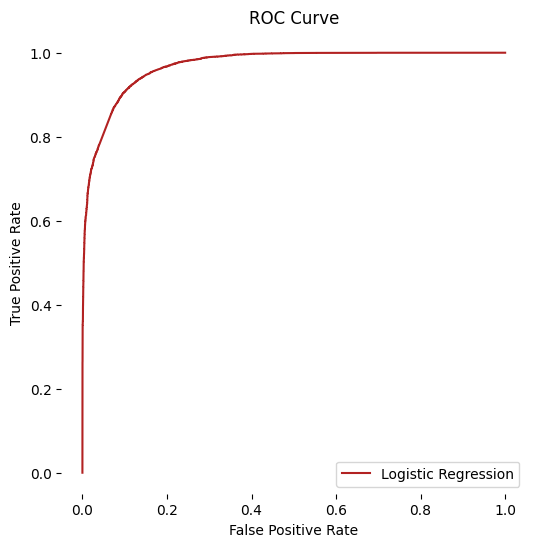

In [43]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

Another good model option!
***
## Feed-Forward Neural Network

Now we're in the deep end! The deep-learning end... But anyways, these are some of the simplest deep learning models. There's a lot to talk about, so I'll leave it to the slides. Let's focus on implementing one via `torch`!

### `torch.Tensor`

These are essentially just fancy `numpy` arrays!

In [44]:
# Set the device (GPU training!)
device = "cpu" # if torch.cuda.is_available() else "cuda" 
print(f"Running models on {device}")

Running models on cpu


In [45]:
# Convert to tensors; there are fancier word embedding implementations (word vectors), but let's focus on what we know
# I hate this https://discuss.pytorch.org/t/creating-a-sparse-tensor-from-csr-matrix/13658/4
features = TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3))

# Outputs a sparse matrics
X_train_sp = features.fit_transform(X_train)
X_test_sp = features.transform(X_test)

In [46]:
# I named them *_t to distinguish them; .to(device) pushes them to the GPU/CPU
# We need to convert the X train and test sparse matrices into a dense one
X_train_t = torch.from_numpy(X_train_sp.toarray().astype(np.float32)).to(device)
X_test_t = torch.from_numpy(X_test_sp.toarray().astype(np.float32)).to(device)
y_train_t = torch.from_numpy(np.array(y_train).astype(np.float32)).to(device)
y_test_t = torch.from_numpy(np.array(y_test).astype(np.float32)).to(device)

In [47]:
# Sparse vector... not a lot of actual "content"
print(X_train_t.max(dim=1))
print(y_train_t)
print(X_train_t.shape, y_train_t.shape)

torch.return_types.max(
values=tensor([0.8114, 0.3672, 0.7720,  ..., 0.4228, 0.4479, 0.7894]),
indices=tensor([1224,  222,  607,  ..., 1506, 1654,  220]))
tensor([0., 0., 0.,  ..., 0., 0., 1.])
torch.Size([88691, 2500]) torch.Size([88691])


### `nn.Sequential`

This is the easiest way to make a simple deep learning model consistent of nothing but a bunch of layers without any tinkering in the middle. Let's break down what this means:

1. We have a vector of 2500 features, `nn.Linear(2500, 5000)` takes these and outputs a vector of 5000 features.
2. We then feed that through the **ReLU** activation function.
3. We lastly take the 5000 features and output a single number with `nn.Linear(5000, 1)`.

**NOTE:** `nn.Dropout(p=0.2)` means, during training, we do not backpropagate through 20% of the weights randomly each step. This helps prevent overfitting. 

In [48]:
model = nn.Sequential(OrderedDict([('lin1', nn.Linear(2500, 5000)),
                                   ("dropout", nn.Dropout(p=0.2)),
                                   ('relu1', nn.ReLU()),
                                   ('lin2', nn.Linear(5000, 1)),
                                   ('sigmoid', nn.Sigmoid())]))
model = model.to(device)

print(model)

Sequential(
  (lin1): Linear(in_features=2500, out_features=5000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu1): ReLU()
  (lin2): Linear(in_features=5000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Loss & The Optimizer

We need a way to measure how off our model is from the actual output, the **loss** function. For a binary classification task, this will be the **Binary Cross-Entropy Loss**, which is analogous to the **Bernoulli Distribution** we usually use for Logistic Regression. The next step is to figure out how to perform **Gradient Descent** each step of an epoch, this is the optimizer's job; to adjust the weights each step based on the loss based on the values gotten during back propagation. Lastly, we use a **learning rate scheduler** to change the learning rate throughout training. This is similar to a concept known as **simulated annealing**, where we start out with large step changes and slowly decrease the amount we step as time goes on. This allows us to explore multiple peaks before settling on one.

In [49]:
learning_rate = 1E-1  # 0.1
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=20_000)

/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training

We train in **batches**, we run through all the training examples in small subsets. Running through all of these subsets is considered one **epoch**. This helps prevent overfitting and reduces the amount of memory needed for one epoch.

#### The Dataset

We can make batching easier by implementing a simple dataset class based on `torch.utils.data`.

In [50]:
class AuthorDataset(Dataset):

    def __init__(self):

        self.x = X_train_t
        self.y = y_train_t.reshape((y_train_t.shape[0], 1))
        self.n = X_train_t.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n

dataset = AuthorDataset()
dataloader = DataLoader(dataset, batch_size=32)

print(dataloader.__iter__().__next__()[0][0])
print(dataloader.__iter__().__next__()[1][0])

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0.])


### The Training Loop

In [51]:
epochs = 3
loss = train_dl(model=model, epochs=epochs, dataloader=dataloader,
                criterion=criterion, optimizer=optimizer)

epoch: 1/3, step: 0/2772, loss: 0.69291
epoch: 1/3, step: 900/2772, loss: 0.64293
epoch: 1/3, step: 1800/2772, loss: 0.37800
epoch: 1/3, step: 2700/2772, loss: 0.30065
epoch: 2/3, step: 0/2772, loss: 0.32691
epoch: 2/3, step: 900/2772, loss: 0.22670
epoch: 2/3, step: 1800/2772, loss: 0.22537
epoch: 2/3, step: 2700/2772, loss: 0.23658
epoch: 3/3, step: 0/2772, loss: 0.26174
epoch: 3/3, step: 900/2772, loss: 0.20361
epoch: 3/3, step: 1800/2772, loss: 0.19139
epoch: 3/3, step: 2700/2772, loss: 0.18166
Final loss: 0.24526801705360413


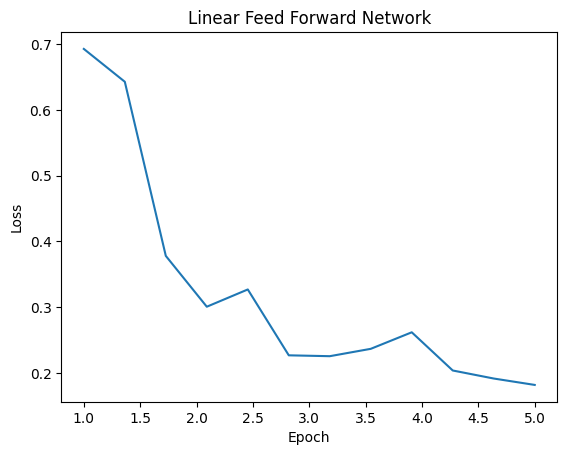

In [52]:
plot_loss(loss, epochs, model_name="Linear Feed Forward Network")

Now let's check its metrics

In [53]:
probabilities = model(X_test_t)
print(probabilities)
print(probabilities.round())

tensor([[9.9987e-01],
        [5.0892e-04],
        [6.8814e-01],
        ...,
        [9.8834e-01],
        [2.5319e-02],
        [1.1407e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)


In [54]:
# Flatten and convert to numpy array
# Detach it from a specific device, squeeze it and convert
probabilities = probabilities.detach().squeeze(dim=1).numpy()
predictions = probabilities.round()
print(probabilities)
print(predictions)

[9.9987161e-01 5.0891779e-04 6.8814057e-01 ... 9.8833966e-01 2.5319306e-02
 1.1407409e-01]
[1. 0. 1. ... 1. 0. 0.]


Accuracy: 0.9006
Precision: 0.9006
Recall: 0.9006
F1 Score: 0.9006


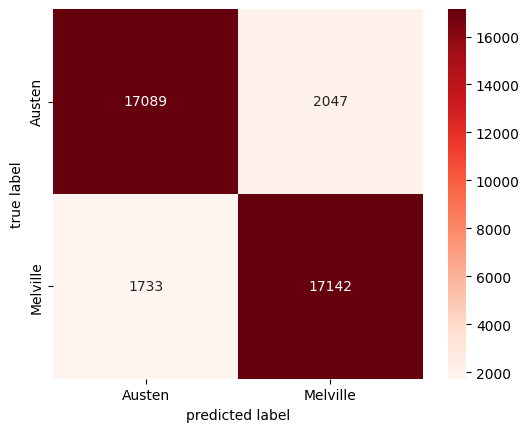

In [55]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

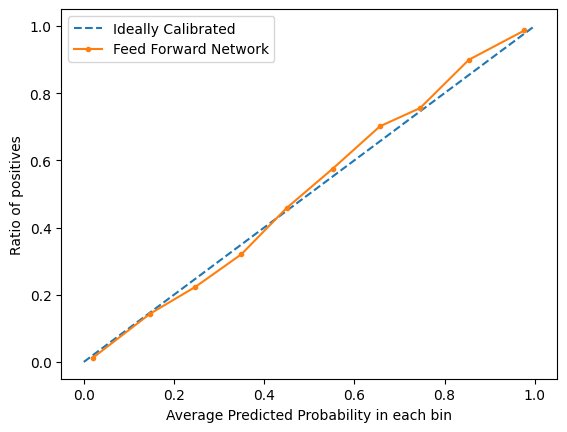

In [56]:
plot_calibration_curve(y_test, probabilities, label="Feed Forward Network")

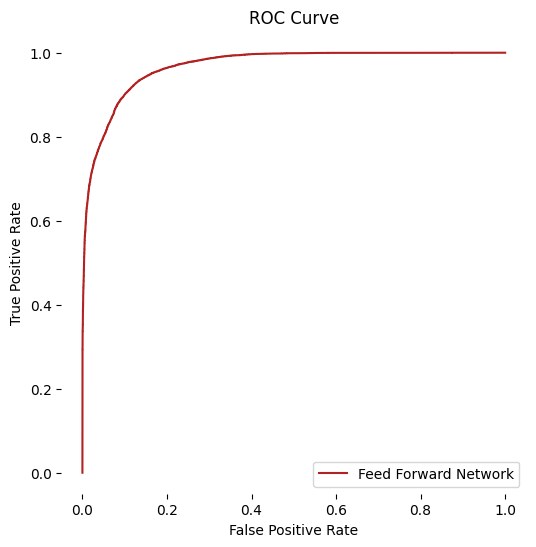

In [57]:
plot_roc_curve(y_test, probabilities, label="Feed Forward Network")

This was our best model yet! But what were some issues/annoyances you saw? Was the increase in performance and calibration from the [logistic regression](#logistic-regression) model worth it?
***
## Recurrent Neural Network

Oh boy! This one's a doozy. This is another deep learning technique that is typically applied in **time-series analysis**, something most NLP tasks can be considered. Essentially, a **time series** is a collection of datapoints given order; a **sequence**. Time series deep learning models allow us to consider the order of data and output answers based on the previous inputs. The most basic of these models is the **Recurrent Neural Network (RNN)** and its modifications the **Long-Short Term Memory (LSTM)** Network and the **Gated Recurrent Unit(GRU)**.

### The Model

Unlike a simple FFNN, we need to make some changes to the output of our model to adapt it for classification. RNNs output an answer (a vector) at each time step, but we only care about the last output for classification! This means `nn.Sequential` isn't enough, and we need to make an actual `nn.Module` class.

In [102]:
# Create the Neural Network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(RNN, self).__init__()

        self.layers = num_layers
        self.hidden_size = hidden_size
        self.device = device

        # batch_size=True means that the input x needs to be a tuple := (batch_size, sequence, input_size)
        # Also GRU (Same everything) and LSTM (Forward needs cell state defined like h0, passed as tuple with h0)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
       
    def forward(self, x):

        h0 = torch.zeros(self.layers, self.hidden_size).to(self.device)

        # out = (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0) # Outputs all the hidden states and the hidden state at step N
        # We want only the last state's vector for all in the batches 
        # out = out[:, -1]

        out = self.fc(self.relu(out))
        
        return self.sigmoid(out)

In [103]:
model = RNN(2500, 500, 8, device).to(device)
dataloader = DataLoader(AuthorDataset(), batch_size=32)
dataloader.__iter__().__next__()[0].shape

torch.Size([32, 2500])

In [104]:
learning_rate = 1E-1  # 0.1
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=1000)

Let's train!

In [105]:
epochs = 3
loss = train_dl(model, epochs, dataloader, criterion, optimizer)

epoch: 1/3, step: 0/2772, loss: 0.69382
epoch: 1/3, step: 900/2772, loss: 0.70882
epoch: 1/3, step: 1800/2772, loss: 0.69253
epoch: 1/3, step: 2700/2772, loss: 0.69328
epoch: 2/3, step: 0/2772, loss: 0.69533
epoch: 2/3, step: 900/2772, loss: 0.70706
epoch: 2/3, step: 1800/2772, loss: 0.69307
epoch: 2/3, step: 2700/2772, loss: 0.69342
epoch: 3/3, step: 0/2772, loss: 0.69446
epoch: 3/3, step: 900/2772, loss: 0.70673
epoch: 3/3, step: 1800/2772, loss: 0.69302
epoch: 3/3, step: 2700/2772, loss: 0.69313
Final loss: 0.6912932395935059


The metrics as always.

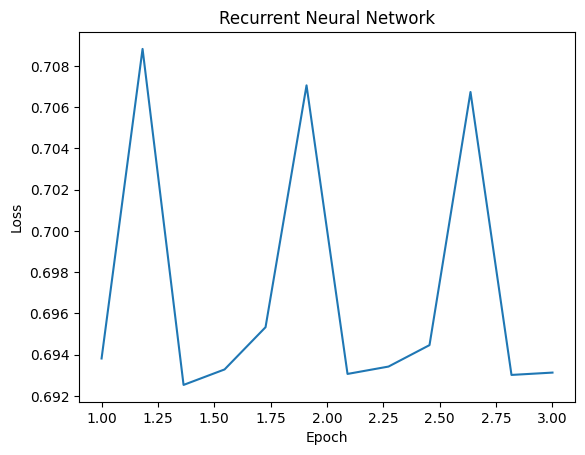

In [107]:
plot_loss(loss, epochs, model_name="Recurrent Neural Network")

Now let's check its metrics

In [108]:
probabilities = model(X_test_t)
print(probabilities)
print(probabilities.round())

tensor([[0.4977],
        [0.4976],
        [0.5011],
        ...,
        [0.5059],
        [0.5058],
        [0.5053]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


In [109]:
# Flatten and convert to numpy array
# Detach it from a specific device, squeeze it and convert
probabilities = probabilities.detach().squeeze(dim=1).numpy()
predictions = probabilities.round()
print(probabilities)
print(predictions)

[0.49769166 0.4976316  0.5011223  ... 0.5058806  0.5058297  0.50534874]
[0. 0. 1. ... 1. 1. 1.]


Accuracy: 0.4965
Precision: 0.4149
Recall: 0.5000
F1 Score: 0.3318


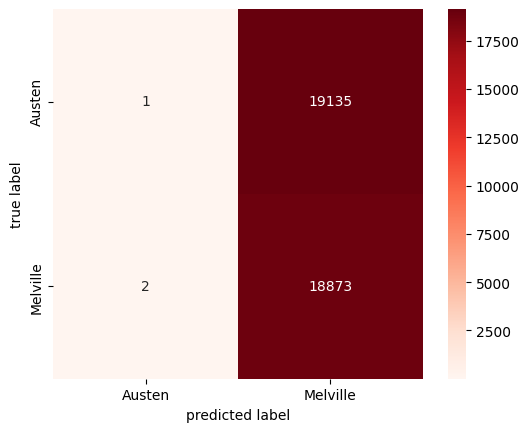

In [110]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

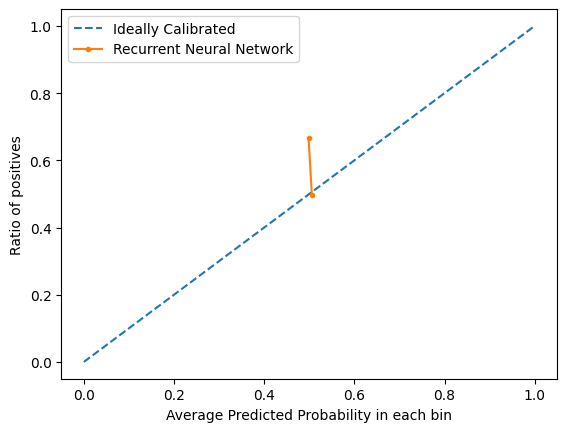

In [111]:
plot_calibration_curve(y_test, probabilities, label="Recurrent Neural Network")

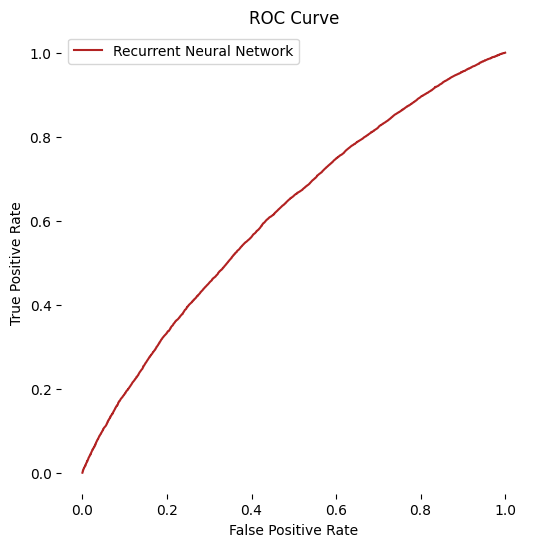

In [112]:
plot_roc_curve(y_test, probabilities, label="Recurrent Neural Network")

I am surprised at how poorly it performed. Perhaps I should have experimented more with the hyperparameters. But either way, it takes a long time to train!
***
## Simple Transformer